In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

In [4]:
# Step 1: Fetch Historical Stock Data

start_date = '2010-01-01'
end_date = '2023-01-01'

# Download historical stock data for Adobe (ADBE) and Microsoft (MSFT) from Yahoo Finance
adbe_data = yf.download('ADBE', start=start_date, end=end_date)
msft_data = yf.download('MSFT', start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [41]:
# Combine the adjusted close prices into a single DataFrame
prices = pd.DataFrame({
    'ADBE': adbe_data['Adj Close'],
    'MSFT': msft_data['Adj Close']
})

# Drop rows with missing values to ensure data integrity
prices.dropna(inplace=True)

prices

,ADBE,MSFT
Date,,
2010-01-04,37.090000,23.347322
2010-01-05,37.700001,23.354858
2010-01-06,37.619999,23.211536
2010-01-07,36.889999,22.970146
2010-01-08,36.689999,23.128555
...,...,...
2022-12-23,338.450012,235.345566
2022-12-27,335.089996,233.600662
2022-12-28,328.329987,231.205109


In [42]:
# Step 2: Kalman Filtering

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

prices['ADBE_scaled'] = (prices['ADBE'] - prices['ADBE'].mean()) / prices['ADBE'].std()
prices['MSFT_scaled'] = (prices['MSFT'] - prices['MSFT'].mean()) / prices['MSFT'].std()

# Estimate the time-varying relationship between ADBE (xt) and MSFT (yt)
xt = prices['ADBE_scaled'].values
yt = prices['MSFT_scaled'].values


In [48]:
print("xt mean:", xt.mean(), "xt std:", xt.std())
print("yt mean:", yt.mean(), "yt std:", yt.std())


xt mean: 0.0 xt std: 0.999847176586561
yt mean: 6.949073210367728e-17 yt std: 0.999847176586561


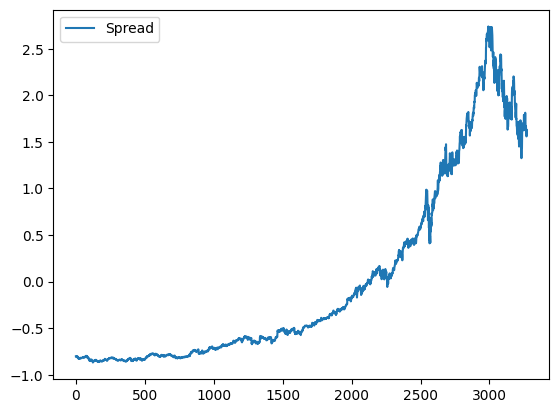

In [49]:
spread = yt - xt * prices['Beta'].values
plt.plot(spread, label='Spread')
plt.legend()
plt.show()


In [43]:
# Apply Kalman Filter to model the relationship
# Kalman Filter setup
kf = KalmanFilter(
    n_dim_obs=1,
    n_dim_state=2,
    initial_state_mean=[0, 0],
    initial_state_covariance=np.eye(2),
    transition_matrices=np.eye(2),
    transition_covariance=0.1 * np.eye(2),
    observation_covariance=0.1
)

In [46]:
# Run the filter with a dynamic observation matrix
state_means, state_covariances = kf.filter(yt)

In [47]:
# Extract alpha (intercept) and beta (slope) from the state means
prices['Alpha'] = state_means[:, 0]
prices['Beta'] = state_means[:, 1]

print(prices[['Alpha', 'Beta']].tail())

               Alpha  Beta
Date                      
2022-12-23  1.612818   0.0
2022-12-27  1.596514   0.0
2022-12-28  1.573464   0.0
2022-12-29  1.609520   0.0
2022-12-30  1.615053   0.0


In [26]:
prices

,ADBE,MSFT,Alpha,Beta,Spread
Date,,,,,
2010-01-04,37.090000,23.347322,11.673661,0.0,11.673661
2010-01-05,37.700001,23.354858,15.618966,0.0,7.735892
2010-01-06,37.619999,23.211536,17.578014,0.0,5.633522
2010-01-07,36.889999,22.970146,18.717749,0.0,4.252397
2010-01-08,36.689999,23.128555,19.517196,0.0,3.611360
...,...,...,...,...,...
2022-12-23,338.450012,235.345566,241.237274,0.0,-5.891709
2022-12-27,335.089996,233.600662,240.510842,0.0,-6.910180
2022-12-28,328.329987,231.205109,239.625635,0.0,-8.420527


In [30]:
# Step 3: Generate Trading Signals
# Calculate the spread
prices['Spread'] = prices['MSFT'] - (prices['Alpha'] + prices['Beta'] * prices['ADBE'])

# Rolling statistics for the spread
rolling_mean = prices['Spread'].rolling(window=20).mean()
rolling_std = prices['Spread'].rolling(window=20).std()

# Define z-score for spread
prices['Z-Score'] = (prices['Spread'] - rolling_mean) / rolling_std

prices

,ADBE,MSFT,Alpha,Beta,Spread,Z-Score
Date,,,,,,
2010-01-04,37.090000,23.347322,11.673661,0.0,11.673661,NaN
2010-01-05,37.700001,23.354858,15.618966,0.0,7.735892,NaN
2010-01-06,37.619999,23.211536,17.578014,0.0,5.633522,NaN
2010-01-07,36.889999,22.970146,18.717749,0.0,4.252397,NaN
2010-01-08,36.689999,23.128555,19.517196,0.0,3.611360,NaN
...,...,...,...,...,...,...
2022-12-23,338.450012,235.345566,241.237274,0.0,-5.891709,-1.311219
2022-12-27,335.089996,233.600662,240.510842,0.0,-6.910180,-1.328669
2022-12-28,328.329987,231.205109,239.625635,0.0,-8.420527,-1.402628


In [31]:
# Generate trading signals
prices['Signal'] = 0
prices.loc[prices['Z-Score'] > 2, 'Signal'] = -1  # Sell Signal
prices.loc[prices['Z-Score'] < -2, 'Signal'] = 1  # Buy Signal

In [39]:
# Step 4: Backtesting
# Initialize columns for profit and loss (PnL) and cumulative PnL
prices['PnL'] = 0
prices['Cumulative_PnL'] = 0

# Simulate trading strategy
transaction_cost = 0.001
positions = {'ADBE': 0, 'MSFT': 0}
for i in range(1, len(prices)):
    signal = prices.iloc[i]['Signal']
    adbe_price = prices.iloc[i]['ADBE']
    msft_price = prices.iloc[i]['MSFT']

    # Enter positions based on signals
    if signal == 1:  # Buy ADBE, Sell MSFT
        positions['ADBE'] = adbe_price
        positions['MSFT'] = -msft_price
    elif signal == -1:  # Sell ADBE, Buy MSFT
        positions['ADBE'] = -adbe_price
        positions['MSFT'] = msft_price
    
    # Calculate PnL for the day
    prices.at[prices.index[i], 'PnL'] = (
        abs((positions['ADBE'] - adbe_price)) + 
        abs((positions['MSFT'] - msft_price))
    ) - transaction_cost * (abs(positions['ADBE']) + abs(positions['MSFT']))

# Calculate cumulative PnL
prices['Cumulative_PnL'] = prices['PnL'].cumsum()

C:\Users\Aadit\AppData\Local\Temp\ipykernel_12100\1686493161.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '61.05485916137695' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prices.at[prices.index[i], 'PnL'] = (


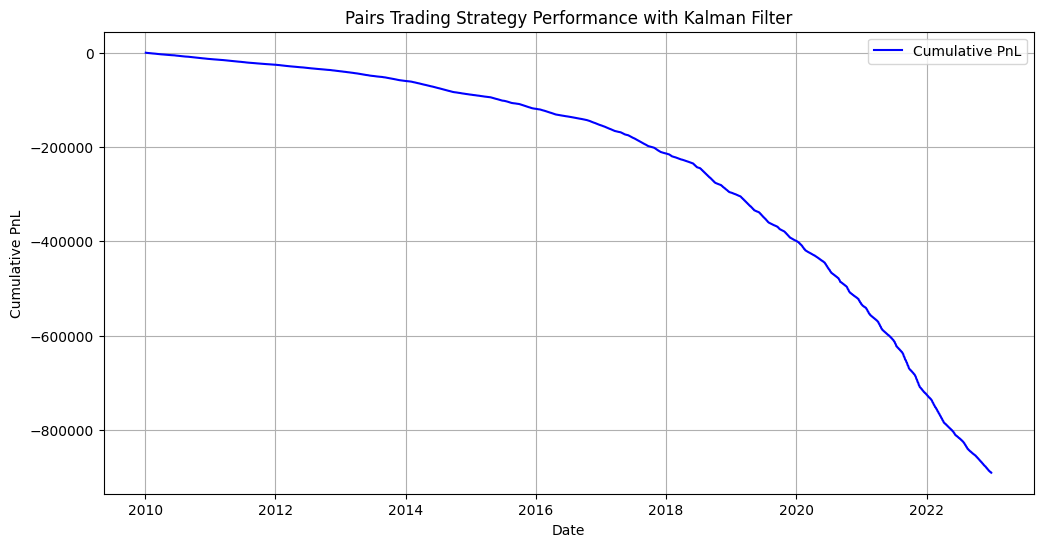

In [33]:
# Plot cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(prices['Cumulative_PnL'], label='Cumulative PnL', color='blue')
plt.title('Pairs Trading Strategy Performance with Kalman Filter')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid()
plt.show()

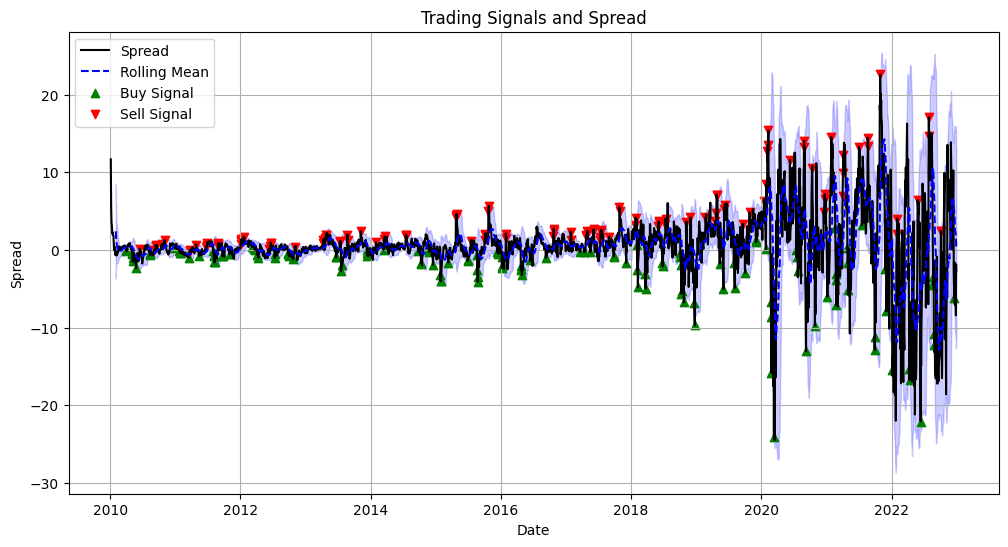

In [40]:
# Plot the spread and signals
plt.figure(figsize=(12, 6))
plt.plot(prices['Spread'], label='Spread', color='black')
plt.plot(rolling_mean, label='Rolling Mean', color='blue', linestyle='dashed')
plt.fill_between(prices.index, rolling_mean - 2 * rolling_std, rolling_mean + 2 * rolling_std, color='blue', alpha=0.2)
plt.scatter(prices.index[prices['Signal'] == 1], prices['Spread'][prices['Signal'] == 1], label='Buy Signal', marker='^', color='green')
plt.scatter(prices.index[prices['Signal'] == -1], prices['Spread'][prices['Signal'] == -1], label='Sell Signal', marker='v', color='red')
plt.title('Trading Signals and Spread')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid()
plt.show()
